In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

In [19]:
g1, g2, e1, e2, R2, SNR, w16a, imag, lweight, sigma_e = np.load("selbias.npy")

In [3]:
g = np.hypot(g1, g2)
e = np.hypot(e1, e2)
g_angle = 0.5*np.arctan2(g2, g1)  # [-pi/2, pi/2)
e_angle = 0.5*np.arctan2(e2, e1)
g_angle[g_angle<0] += np.pi  # [0, pi)
e_angle[e_angle<0] += np.pi
phi_plus = np.abs(g_angle - e_angle)
# Can't be more than pi/2 misaligned.  Need to reflect
phi_plus[phi_plus>np.pi/2] = np.pi - phi_plus[phi_plus>np.pi/2]

In [4]:
ePairMean = np.mean(np.reshape(e, (len(e)//2, 2)), axis=1)
R2PairMean = np.mean(np.reshape(R2, (len(R2)//2, 2)), axis=1)
SNRPairMean = np.mean(np.reshape(SNR, (len(SNR)//2, 2)), axis=1)
imagPairMean = np.mean(np.reshape(imag, (len(imag)//2, 2)), axis=1)
lweightPairMean = np.mean(np.reshape(lweight, (len(lweight)//2, 2)), axis=1)

In [5]:
# How many gals does each selection leave behind?
print("total", len(R2))
print()
print("R2", np.sum(R2 > 0.3))
print("imag", np.sum(imag < 24.5))
print("SNR", np.sum(SNR > 10.0))
print()
print("R2 & imag", np.sum((R2 > 0.3) & (imag < 24.5)))
print("R2 & SNR", np.sum((R2 > 0.3) & (SNR > 10.0)))
print("imag & SNR", np.sum((imag < 24.5) & (SNR > 10.0)))
print()
print("all", np.sum((R2 > 0.3) & (imag < 24.5) & (SNR > 10.0)))

total 2529442

R2 2350942
imag 2040677
SNR 2483522

R2 & imag 1889685
R2 & SNR 2305153
imag & SNR 2018842

all 1867856


In [6]:
# What's the 20, 40, 60, 80 percentile in ellipticity?
print(np.percentile(e, [20, 40, 60, 80]))
# ... of things that get selected?
wselect = (R2 > 0.3) & (imag < 24.5) & (SNR > 10.0)
print(np.percentile(e[wselect], [20, 40, 60, 80]))
ebins = [0.0, 0.33, 0.50, 0.66, 0.82, 2.0]
ebinmeans = []
for emin, emax in zip(ebins[:-1], ebins[1:]):
    w = (e > emin) & (e < emax)
    ebinmean = np.mean(e[wselect & w])
    print(emin, emax, ebinmean)
    ebinmeans.append(ebinmean)

[ 0.33931499  0.51737763  0.67938885  0.84425658]
[ 0.3261187   0.50055651  0.66054736  0.82075355]
0.0 0.33 0.211979663185
0.33 0.5 0.416859469099
0.5 0.66 0.580451188698
0.66 0.82 0.739263414405
0.82 2.0 0.952345726128


/Users/josh/src/lsstsw3/miniconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


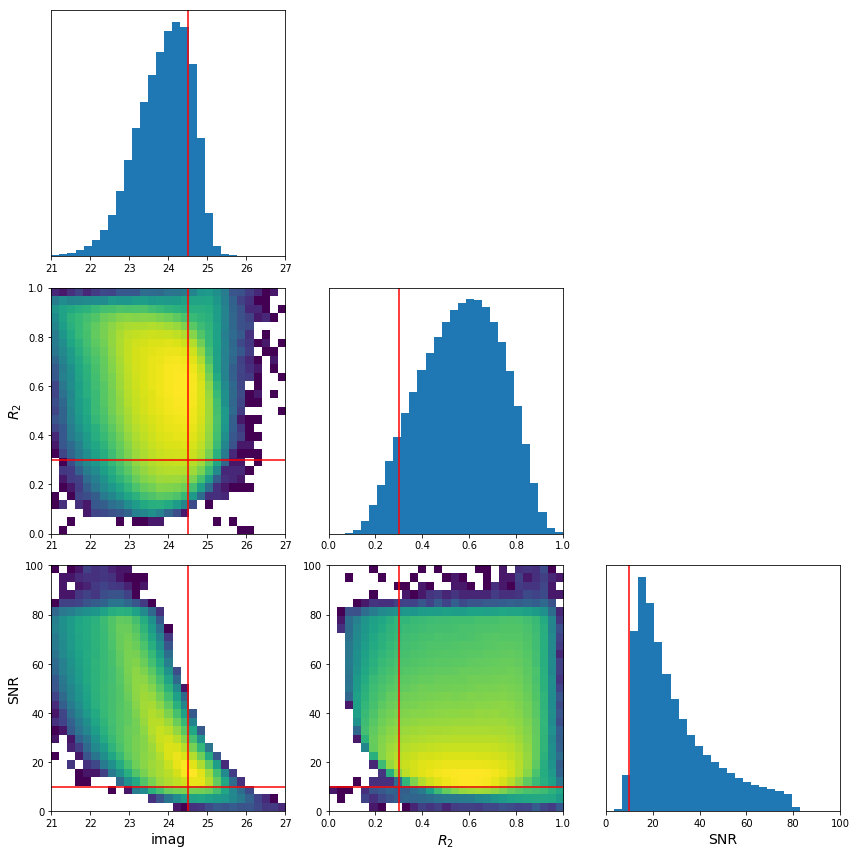

In [7]:
# Manual corner plot
imagbins = np.linspace(21, 27, 30)
R2bins = np.linspace(0, 1, 30)
SNRbins = np.linspace(0, 100, 30)

fig = plt.figure(figsize=(12, 12))

imaghistax = fig.add_subplot(331)
imaghistax.hist(imag, bins=imagbins)
imaghistax.set_xlim(imagbins[0], imagbins[-1])
imaghistax.set_yticks([])
imaghistax.axvline(24.5, c='r')


imagR2ax = fig.add_subplot(334)
imagR2ax.hist2d(imag, R2, bins=[imagbins, R2bins], norm=LogNorm())
imagR2ax.axvline(24.5, c='r')
imagR2ax.axhline(0.3, c='r')
imagR2ax.set_ylabel("$R_2$", fontsize=14)

R2histax = fig.add_subplot(335)
R2histax.hist(R2, bins=R2bins)
R2histax.set_xlim(R2bins[0], R2bins[-1])
R2histax.set_yticks([])
R2histax.axvline(0.3, c='r')


imagSNRax = fig.add_subplot(337)
imagSNRax.hist2d(imag, SNR, bins=[imagbins, SNRbins], norm=LogNorm())
imagSNRax.axvline(24.5, c='r')
imagSNRax.axhline(10.0, c='r')
imagSNRax.set_xlabel("imag", fontsize=14)
imagSNRax.set_ylabel("SNR", fontsize=14)

R2SNRax = fig.add_subplot(338)
R2SNRax.hist2d(R2, SNR, bins=[R2bins, SNRbins], norm=LogNorm())
R2SNRax.axvline(0.3, c='r')
R2SNRax.axhline(10.0, c='r')
R2SNRax.set_xlabel("$R_2$", fontsize=14)

SNRhistax = fig.add_subplot(339)
SNRhistax.hist(SNR, bins=SNRbins)
SNRhistax.set_xlim(SNRbins[0], SNRbins[-1])
SNRhistax.set_yticks([])
SNRhistax.axvline(10.0, c='r')
SNRhistax.set_xlabel("SNR", fontsize=14)


fig.tight_layout()
fig.show()

In [8]:
def plotrange(X):
    Xrange = np.percentile(X, [2.0, 98.0])
    span = Xrange[1] - Xrange[0]
    return Xrange[0]-span*0.2, Xrange[1]+span*0.2

In [9]:
def getWPair(Z, e, Zmin, Zmax, emin, emax, seltype='random', randomizer=None, otherselect=None):
    if seltype == 'random':
        if randomizer is None:
            randomizer = np.random.choice(2, size=len(Z)//2) + np.arange(0, len(Z), 2)
        wpair = Z[randomizer] > Zmin
        wpair &= Z[randomizer] < Zmax
        wpair &= e[randomizer] > emin
        wpair &= e[randomizer] < emax
        if otherselect is not None:
            wpair &= otherselect[randomizer]
    elif seltype == 'mean':
        Zmean = np.mean(np.reshape(Z, (len(Z)//2, 2)), axis=1)
        emean = np.mean(np.reshape(e, (len(e)//2, 2)), axis=1)
        wpair = Zmean > Zmin
        wpair &= Zmean < Zmax
        wpair &= emean > emin
        wpair &= emean < emax
        if otherselect is not None:
            otherselect = np.logical_or(
                *np.reshape(otherselect, (len(otherselect)//2, 2)).T,
            )
            wpair &= otherselect
    return wpair

In [10]:
def Acoef(e, g, phi_plus, Z, Zcut, Zspan, Zname, 
          weight=None, ebins=(0.0, 0.33, 0.50, 0.66, 0.82, 2.0), ebindiff=1,
          ylim=None, otherselect=None, nbins=50,
          seltype='random', clipend=0):
    """
    e = ellipticity magnitudes.  Should come in pairs.
    g = shear magnitudes
    phi_plus = abs(angle) between ellipticity and shear
    Z = variable being used to define selection
    Zcut = cutoff value for Z
    Zspan = span defining "near Zcut", can be a list to make multiple reports/trendlines
    Zname = name of Z variable.  Used in plots/text reports
    weights = weight to apply to each Z
    ebins = [0, 2]  list defining ellipticity bins in which to perform analysis
    ebindiff = difference between ebin indices forming bins
    otherselect = boolean array for doing additional selection
    nbins = # of bins to use for Z
    seltype = selection type.  
              'random' means select using one galaxy randomly chosen from each pair
              'mean' means selecting using mean value of each pair
    """
    if not hasattr(Zspan, '__getitem__'):
        Zspan = [Zspan]

    if weight is None:
        weight = w16a
    else:
        weight = w16a * weight

    # Pick one gal from pair randomly to use in selection
    randomizer = np.random.choice(2, size=len(Z)//2) + np.arange(0, len(Z), 2)

    wpair = getWPair(Z, e, Zcut-Zspan[0], Zcut+Zspan[0], ebins[0], ebins[-1], 
                     seltype=seltype, randomizer=randomizer, otherselect=otherselect)

    x = g[::2][wpair] * (np.cos(2*phi_plus[::2][wpair]) - np.cos(2*phi_plus[1::2][wpair]))
    y = Z[::2][wpair] - Z[1::2][wpair]
    pair_weight = 0.5*(weight[1::2] + weight[::2])[wpair]

    xrange = plotrange(x)
    yrange = plotrange(y)
    
    fig, ax = plt.subplots(1, 1)
    im = ax.hist2d(x, y, 
                   bins=[np.linspace(xrange[0], xrange[1], nbins),
                         np.linspace(yrange[0], yrange[1], nbins)],
                   norm=LogNorm(),
                   weights=pair_weight)

    # For the trend lines and text report, loop over possible Zspans and ebins
    xedges = np.linspace(xrange[0], xrange[1], nbins)

    result = []
    for emin, emax, ls in zip(ebins[:-ebindiff], ebins[ebindiff:], 
                              itertools.cycle(['-', '--', ':', '-.'])):        
        print()
        print()
        print("emin = {}, emax = {}".format(emin, emax))

        for Zsp, c in zip(Zspan, itertools.cycle(['r', 'g', 'b', 'k'])):
            wpair = getWPair(Z, e, Zcut-Zsp, Zcut+Zsp, emin, emax, 
                             seltype=seltype, randomizer=randomizer, otherselect=otherselect)

            x = g[::2][wpair] * (np.cos(2*phi_plus[::2][wpair]) - np.cos(2*phi_plus[1::2][wpair]))
            y = Z[::2][wpair] - Z[1::2][wpair]
            pair_weight = 0.5*(weight[1::2] + weight[::2])[wpair]

            xs = []
            ys = []
            for xlo, xhi in zip(xedges[:-1], xedges[1:]):
                ww = (xlo < x) & (x < xhi)
                if np.sum(ww) < 100: # Don't include poorly populated bins
                    continue
                xs.append(0.5*(xlo+xhi))  # Middle of bin, could use bin average?
                ys.append(np.sum(y[ww]*pair_weight[ww])/np.sum(pair_weight[ww]))
            wfit = np.isfinite(ys)            
            xs = np.array(xs)[wfit]
            ys = np.array(ys)[wfit]
            if clipend is not 0:
                xs = xs[clipend:-clipend]
                ys = ys[clipend:-clipend]
            ax.plot(xs, ys, c=c, ls=ls, label="e in [{}, {}], Zsp = {}".format(emin, emax, Zsp))
            coefs = np.polyfit(xs, ys, deg=1)
            print()
            print("Zspan = {}".format(Zsp))
            print("  m={:8.3g}  b={:8.2g}".format(coefs[0], coefs[1]))
            emean = np.mean(np.mean(np.reshape(e, (len(e)//2, 2)), axis=1)[wpair])
            result.append([Zsp, emean, coefs[0], coefs[1]])

    ax.legend()
    ax.axhline(0.0, c='k')
    ax.axvline(0.0, c='k')

    ax.set_xlabel("$\gamma (\cos(2 \phi_+^{(1)}) - \cos(2 \phi_+^{(2)}))$", fontsize=15)
    ylabel="${{{0}}}^{{(1)}} - {{{0}}}^{{(2)}}$".format(Zname)
    ax.set_ylabel(ylabel, fontsize=15)
    if ylim is not None:
        ax.set_ylim(ylim)
    plt.tight_layout()
    return np.array(result)

In [11]:
# What's the 20, 40, 60, 80 percentile in ellipticity?
# ... of things that get selected?
wselect = (R2 > 0.3) & (imag < 24.5) & (SNR > 10.0)
epercentiles = range(20, 100, 20)
print(list(epercentiles))
ebins = [0]+list(np.percentile(e[wselect], epercentiles))+[2]
print(ebins)

[20, 40, 60, 80]
[0, 0.32611869901896279, 0.50055651391591316, 0.66054735866285619, 0.82075355008942763, 2]




emin = 0, emax = 0.3261186990189628

Zspan = 0.05
  m=  0.0773  b= 0.00029


emin = 0.3261186990189628, emax = 0.5005565139159132

Zspan = 0.05
  m=    0.11  b=-0.00031


emin = 0.5005565139159132, emax = 0.6605473586628562

Zspan = 0.05
  m=   0.119  b=  0.0011


emin = 0.6605473586628562, emax = 0.8207535500894276

Zspan = 0.05
  m=   0.164  b= 7.9e-05


emin = 0.8207535500894276, emax = 2

Zspan = 0.05
  m=   0.124  b=-0.00026


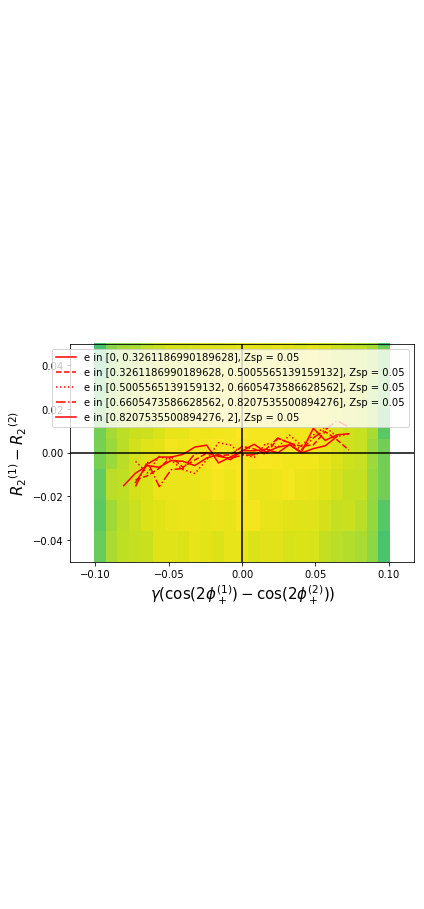

In [12]:
# When evaluating R2 selection bias, we should implement the cuts in SNR and imag
otherselect = np.repeat((SNRPairMean > 10.0) & (imagPairMean < 24.5), 2)
AR2 = Acoef(e, g, phi_plus, R2, 0.3, [0.05], 'R_2',
            ylim=(-0.05, 0.05), 
            ebins=ebins, ebindiff=1,
            otherselect=otherselect, nbins=30, weight=np.repeat(lweightPairMean, 2),
            seltype='mean', clipend=2)

[ 0.0694726   0.07721858]


(0, 0.18)

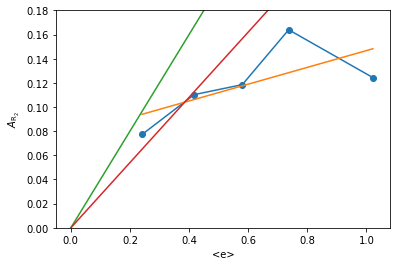

In [13]:
AR2poly = np.polyfit(AR2[:, 1], AR2[:, 2], deg=1)
print(AR2poly)
plt.plot(AR2[:, 1], AR2[:, 2])
plt.scatter(AR2[:, 1], AR2[:, 2])
plt.plot(AR2[:, 1], AR2[:, 1]*AR2poly[0] + AR2poly[1])
plt.plot([0.0, 1.0], [0.0, 0.4])
plt.plot([0.0, 1.0], [0.0, 0.27])
plt.ylabel("$A_\mathrm{R_2}$")
plt.xlabel("<e>")
plt.ylim(0, 0.18)



emin = 0.0, emax = 0.33

Zspan = 5
  m=   -4.32  b=   0.031


emin = 0.33, emax = 0.5

Zspan = 5
  m=   -1.84  b=   0.015


emin = 0.5, emax = 0.66

Zspan = 5
  m=    -2.7  b=   0.021


emin = 0.66, emax = 0.82

Zspan = 5
  m=   -3.46  b=  -0.073


emin = 0.82, emax = 2.0

Zspan = 5
  m=   -2.89  b=  -0.057


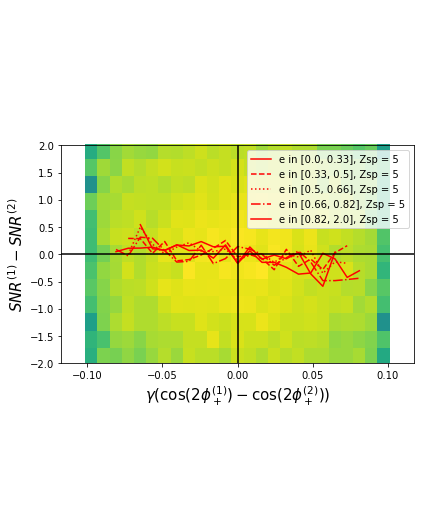

In [14]:
# For SNR bias, implement cuts in R2 and imag
otherselect = np.repeat((R2PairMean > 0.3) & (imagPairMean < 24.5), 2)
ASNR = Acoef(e, g, phi_plus, SNR, 10.0, [5], 'SNR',
             ylim=(-2, 2),
             otherselect=otherselect, nbins=30, weight=np.repeat(lweightPairMean, 2),
             seltype='mean', clipend=2)

[ 0.73575249 -3.47272209]
[-3.0383658]


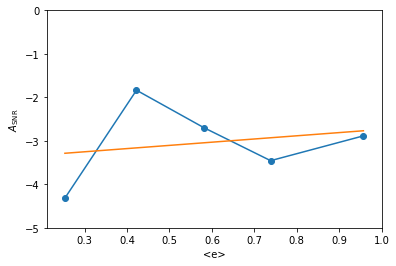

In [15]:
ASNRpoly = np.polyfit(ASNR[:, 1], ASNR[:, 2], deg=1)
print(ASNRpoly)
plt.plot(ASNR[:, 1], ASNR[:, 2])
plt.scatter(ASNR[:, 1], ASNR[:, 2])
plt.plot(ASNR[:, 1], ASNR[:, 1]*ASNRpoly[0] + ASNRpoly[1])
plt.ylabel("$A_\mathrm{SNR}$")
plt.xlabel("<e>")
plt.ylim(-5.0, 0)
# Try a constant fit too...
ASNRConstPoly = np.polyfit(ASNR[:, 1], ASNR[:, 2], deg=0)
print(ASNRConstPoly)



emin = 0.0, emax = 0.33

Zspan = 0.1
  m=  0.0516  b=  0.0027


emin = 0.33, emax = 0.5

Zspan = 0.1
  m=  0.0756  b= -0.0012


emin = 0.5, emax = 0.66

Zspan = 0.1
  m=  0.0845  b=-0.00048


emin = 0.66, emax = 0.82

Zspan = 0.1
  m=   0.122  b=  0.0026


emin = 0.82, emax = 2.0

Zspan = 0.1
  m=   0.186  b= -0.0016


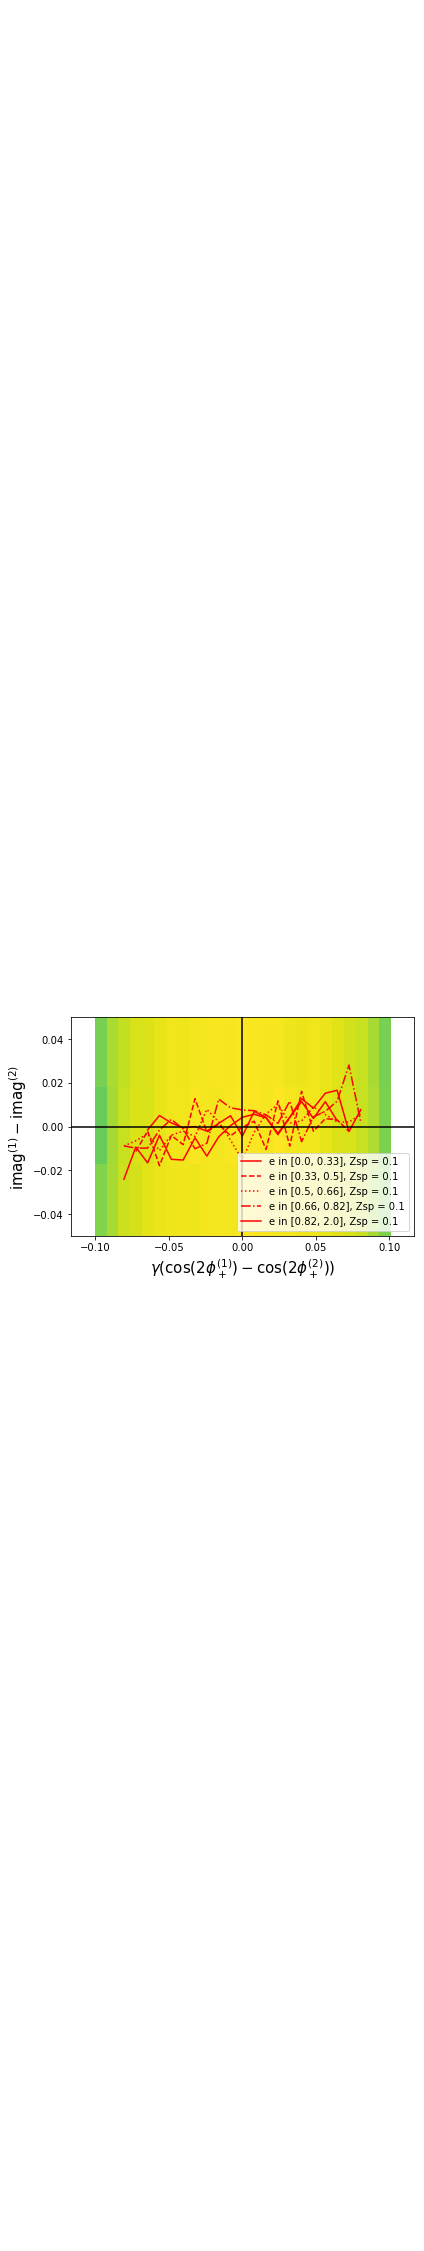

In [16]:
# For imag bias, implement cuts in SNR and R2
otherselect = np.repeat((R2PairMean > 0.3) & (SNRPairMean > 10.0), 2)
Aimag = Acoef(e, g, phi_plus, imag, 24.5, [0.1], '\mathrm{imag}',
              ylim=(-0.05, 0.05),
              otherselect=otherselect, nbins=30, weight=np.repeat(lweightPairMean, 2),
              seltype='mean', clipend=2)

[ 0.18357683 -0.00455446]


(0, 0.2)

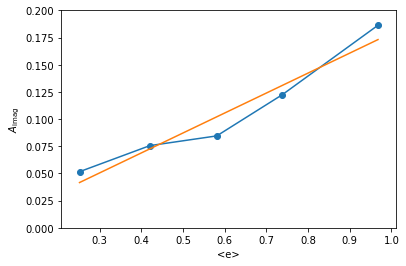

In [17]:
Aimagpoly = np.polyfit(Aimag[:, 1], Aimag[:, 2], deg=1)
print(Aimagpoly)
plt.plot(Aimag[:, 1], Aimag[:, 2])
plt.scatter(Aimag[:, 1], Aimag[:, 2])
plt.plot(Aimag[:, 1], Aimag[:, 1]*Aimagpoly[0] + Aimagpoly[1])
plt.ylabel("$A_\mathrm{imag}$")
plt.xlabel("<e>")
plt.ylim(0, 0.20)

In [20]:
def selbiasFactor(sige, Am, Ab):
    """
    pedge = differential probability of observing galaxy at selection edge
    R = shear responsivity
    mcal = calibration bias
    sige = intrinsic ellipticity distribution width
    Am = linear part of selection bias effect
    Ab = constant part of selection bias effect
    """
    from scipy.special import erf
    # Wolfram alpha reports integral results:
    # Integrate[x^2*(a*x+b) exp(-x^2/(2 s^2))/s^2, {x, 0, 1}]
    # = exp(-1/(2*s^2))*(a*(2*(exp(1/(s*s^2))-1)*s^2-1)-b)+sqrt(pi/2)*b*s*erf(1/sqrt(2*s^2))
    oneOverTwoSSquared = 1./(2*sige**2)
    term1 = np.exp(-oneOverTwoSSquared)*(Am*(2*(np.exp(oneOverTwoSSquared)-1)*sige**2-1)-Ab)
    term2 = np.sqrt(np.pi/2)*Ab*sige*erf(1/np.sqrt(2*sige**2))
    return term1 + term2

In [21]:
hists = np.loadtxt(open("s16a_v2.0_v4sims_wtdist_overall_distributions_1d.dat"))
colcat = ['R2', 'SNR', 'imag', 'lweight']
coltype = ['Zdata', 'Ndata', 'Zsim', 'Nsim']
h = np.core.records.fromrecords(hists, names=['{}_{}'.format(cc, ct) for cc in colcat for ct in coltype])

R2 data 1.223167914278798
R2 sim 1.0654876506223239


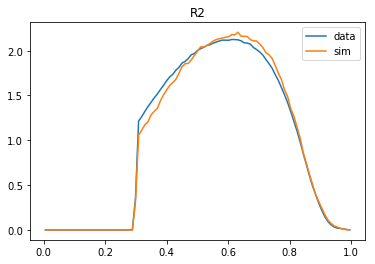

SNR data 0.0004989938108871288
SNR sim 0.0013248776412268738


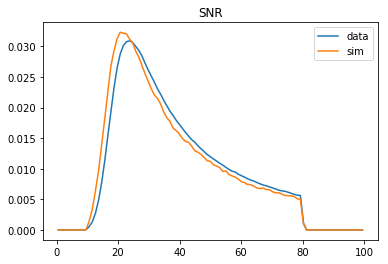

imag data 0.7769157087209555
imag sim 0.722241898024481


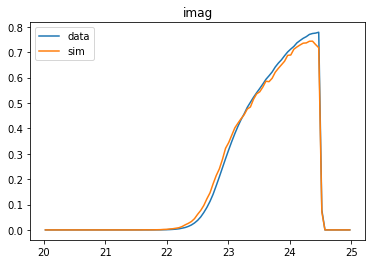

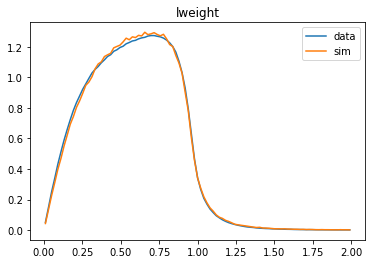

In [22]:
edge = {'R2':0.31, 'SNR':10.5, 'imag':24.45}
for cc in colcat:
    plt.figure()
    for d in ['data', 'sim']:
        x = h['{}_Z{}'.format(cc, d)]
        y = h['{}_N{}'.format(cc, d)]
        y /= np.trapz(y, x)
        plt.plot(x, y, label=d)
        if cc in edge:
            print(cc, d, np.interp(edge[cc], x, y))
    plt.legend()
    plt.title(cc)
    plt.show()

In [23]:
# R2
# Still needs to be multiplied by 1 / (R * (1 + m_cal)) 
sige = 0.39
sbF = selbiasFactor(sige, 0.06425069, 0.08096031)
pedge = 1.22
print(sbF * pedge / 4)

0.0160290237621


In [24]:
# SNR
sige = 0.39
sbF = selbiasFactor(sige, 0, -3.02)
pedge = 0.0005
print(sbF * pedge / 4)

-0.000168509257079


In [26]:
# imag
sige = 0.39
sbF = selbiasFactor(sige, 0.18236482, -0.003416)
pedge = -0.776 # Upper limit, so use negative sign
print(sbF * pedge / 4)

-0.00874284588588


In [27]:
# Try Gaussian analytic and simulated noise-free Sersic/Kolmogorov estimate for A_R2 too.
sige = 0.39
sbFGauss = selbiasFactor(sige, 0.4, 0.0)
sbFSK = selbiasFactor(sige, 0.27, 0.0)
pedge = 1.22
print(sbFGauss * pedge / 4)
print(sbFSK * pedge / 4)

0.0311688898624
0.0210390006571


In [28]:
# Find unique values of true shear
uniqGs = set(list(tuple(g_) for g_ in np.array([g1, g2]).T))

In [63]:
def unBiasedMCal():
    gTable = []
    for g12 in uniqGs:
        # Initially select on a random gal from each pair.  
        # Average the ellipticity vals from *both* gals in selected pair.
        wpair = (g1[::2] == g12[0]) & (g2[::2] == g12[1])
        randomizer = np.random.choice(2, size=len(SNR)//2) + np.arange(0, len(SNR), 2)
        wpair &= SNR[randomizer] > 10.0
        wpair &= R2[randomizer] > 0.3
        wpair &= imag[randomizer] < 24.5
        wgal = np.repeat(wpair, 2) # turns pair selection into gal selection
        assert np.all(wpair == wgal[::2])
        assert np.all(wpair == wgal[1::2])

        Den = lweight[wgal]*w16a[wgal]
        g1Num = e1[wgal]
        g1Num *= Den
        g2Num = e2[wgal]
        g2Num *= Den
        DSum = np.sum(Den)
        if DSum != 0:
            gTable.append([g12[0], g12[1], np.sum(g1Num)/DSum, np.sum(g2Num)/DSum])
    return gTable
gTable = np.array(unBiasedMCal())

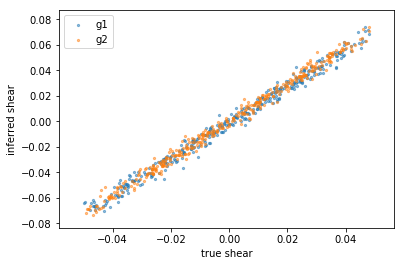

In [64]:
plt.scatter(gTable[:,0], gTable[:,2], alpha=0.5, s=5, label='g1')
plt.scatter(gTable[:,1], gTable[:,3], alpha=0.5, s=5, label='g2')
plt.legend(loc='upper left')
plt.xlabel('true shear')
plt.ylabel('inferred shear')
plt.show()

In [65]:
g1Poly = np.polyfit(gTable[:,0], gTable[:,2], deg=1)
g2Poly = np.polyfit(gTable[:,1], gTable[:,3], deg=1)
print(g1Poly)
print(g2Poly)

[  1.42146773e+00  -8.24408597e-04]
[  1.44861653e+00   2.40985673e-04]


In [66]:
def selBiasMCal():
    gTable = []
    for g12 in uniqGs:
        # Select each gal individually
        wgal = (g1 == g12[0]) & (g2 == g12[1])
        wgal &= SNR > 10.0
        wgal &= R2 > 0.3
        wgal &= imag < 24.5

        Den = lweight[wgal]*w16a[wgal]
        g1Num = e1[wgal]
        g1Num *= Den
        g2Num = e2[wgal]
        g2Num *= Den
        DSum = np.sum(Den)
        if DSum != 0:
            gTable.append([g12[0], g12[1], np.sum(g1Num)/DSum, np.sum(g2Num)/DSum])
    return gTable
gTableSelBias = np.array(selBiasMCal())

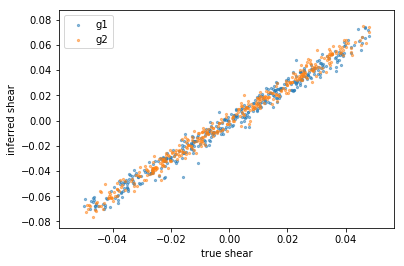

In [67]:
plt.scatter(gTableSelBias[:,0], gTableSelBias[:,2], alpha=0.5, s=5, label='g1')
plt.scatter(gTableSelBias[:,1], gTableSelBias[:,3], alpha=0.5, s=5, label='g2')
plt.legend(loc='upper left')
plt.xlabel('true shear')
plt.ylabel('inferred shear')
plt.show()

In [68]:
g1PolySelBias = np.polyfit(gTableSelBias[:,0], gTableSelBias[:,2], deg=1)
g2PolySelBias = np.polyfit(gTableSelBias[:,1], gTableSelBias[:,3], deg=1)
print(g1PolySelBias)
print(g2PolySelBias)

[  1.42505661e+00  -1.01755976e-03]
[  1.45081001e+00   1.59572913e-04]


In [69]:
def isolateMCal(pairSNR=False, pairR2=False, pairIMag=False):
    """
    @param pairSNR  select pair instead of gal on SNR
    @param pairR2   select pair instead of gal on R2
    @param pairIMag select pair instead of gal in imag
    """
    gTable = []
    for g12 in uniqGs:
        # Select on a random gal from each pair.  Average vals from *both* gals though.  Should be unbiased.
        wpair = (g1[::2] == g12[0]) & (g2[::2] == g12[1])
        randomizer = np.random.choice(2, size=len(SNR)//2) + np.arange(0, len(SNR), 2)
        # First apply pairwise selection
        if pairSNR:
            wpair &= SNR[randomizer] > 10.0
        if pairR2:
            wpair &= R2[randomizer] > 0.3
        if pairIMag:
            wpair &= imag[randomizer] < 24.5
        wgal = np.repeat(wpair, 2)
        assert np.all(wpair == wgal[::2])
        assert np.all(wpair == wgal[1::2])
        # Now make individual galaxy selection
        if not pairSNR:
            wgal &= SNR > 10.0
        if not pairR2:
            wgal &= R2 > 0.3
        if not pairIMag:
            wgal &= imag < 24.5

        Den = lweight[wgal]
        g1Num = e1[wgal]
        g1Num *= Den
        g2Num = e2[wgal]
        g2Num *= Den
        DSum = np.sum(Den)
        if DSum != 0:
            gTable.append([g12[0], g12[1], np.sum(g1Num)/DSum, np.sum(g2Num)/DSum])
    return gTable

In [70]:
gTableR2 = np.array(isolateMCal(pairSNR=True, pairR2=False, pairIMag=True))
gTableSNR = np.array(isolateMCal(pairSNR=False, pairR2=True, pairIMag=True))
gTableIMag = np.array(isolateMCal(pairSNR=True, pairR2=True, pairIMag=False))

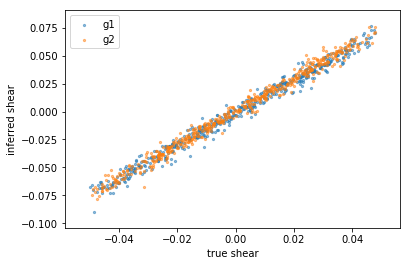

In [71]:
plt.scatter(gTableR2[:,0], gTableR2[:,2], alpha=0.5, s=5, label='g1')
plt.scatter(gTableR2[:,1], gTableR2[:,3], alpha=0.5, s=5, label='g2')
plt.legend(loc='upper left')
plt.xlabel('true shear')
plt.ylabel('inferred shear')
plt.show()

In [72]:
g1PolyR2 = np.polyfit(gTableR2[:,0], gTableR2[:,2], deg=1)
g2PolyR2 = np.polyfit(gTableR2[:,1], gTableR2[:,3], deg=1)
print(g1PolyR2)
print(g2PolyR2)

[  1.46098640e+00  -1.21209882e-03]
[  1.48614324e+00   1.34625488e-04]


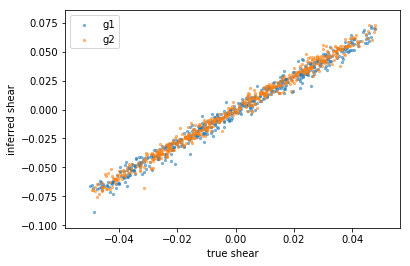

In [73]:
plt.scatter(gTableSNR[:,0], gTableSNR[:,2], alpha=0.5, s=5, label='g1')
plt.scatter(gTableSNR[:,1], gTableSNR[:,3], alpha=0.5, s=5, label='g2')
plt.legend(loc='upper left')
plt.xlabel('true shear')
plt.ylabel('inferred shear')
plt.show()

In [74]:
g1PolySNR = np.polyfit(gTableSNR[:,0], gTableSNR[:,2], deg=1)
g2PolySNR = np.polyfit(gTableSNR[:,1], gTableSNR[:,3], deg=1)
print(g1PolySNR)
print(g2PolySNR)

[  1.43243411e+00  -1.08680535e-03]
[  1.45208796e+00   1.09666829e-04]


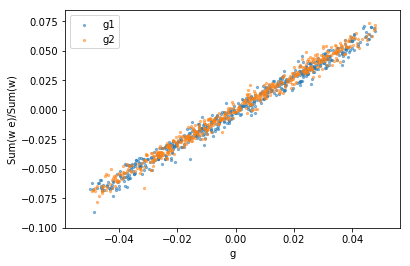

In [86]:
plt.scatter(gTableIMag[:,0], gTableIMag[:,2], alpha=0.5, s=5, label='g1')
plt.scatter(gTableIMag[:,1], gTableIMag[:,3], alpha=0.5, s=5, label='g2')
plt.legend(loc='upper left')
plt.xlabel('g')
plt.ylabel('Sum(w e)/Sum(w)')
plt.show()

In [76]:
g1PolyIMag = np.polyfit(gTableIMag[:,0], gTableIMag[:,2], deg=1)
g2PolyIMag = np.polyfit(gTableIMag[:,1], gTableIMag[:,3], deg=1)
print(g1PolyIMag)
print(g2PolyIMag)

[  1.41804462e+00  -1.07485526e-03]
[  1.43786242e+00   2.34736760e-04]


In [83]:
# R2 selection bias
print(g1PolyR2[0]/g1Poly[0]-1)
print(g2PolyR2[0]/g2Poly[0]-1)
print("edge calculation: ", 0.0160290237621/(0.5*(g1Poly[0]+g2Poly[0])))

0.0278013185767
0.0259052054602
edge calculation:  0.0111697234736


In [84]:
# SNR selection bias
print(g1PolySNR[0]/g1Poly[0]-1)
print(g2PolySNR[0]/g2Poly[0]-1)
print("edge calculation: ", -0.000168509257079/(0.5*(g1Poly[0]+g2Poly[0])))

0.0077148330981
0.00239637578947
edge calculation:  -0.00011742460628


In [85]:
# imag selection bias
print(g1PolyIMag[0]/g1Poly[0]-1)
print(g2PolyIMag[0]/g2Poly[0]-1)
print("edge calculation: ", -0.00874284588588/(0.5*(g1Poly[0]+g2Poly[0])))

-0.00240814817675
-0.0074237123026
edge calculation:  -0.0060923966654
